# Zusammenfassung Regularisierung

## Imports

In [0]:
# TensorFlow ≥2.0 is required for this notebook
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# check if GPU is available as this notebook will be very slow without GPU
if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

!pip install --upgrade deeplearning2020
from deeplearning2020 import helpers

# jupyters magic command for matplotlib
%matplotlib inline

Requirement already up-to-date: deeplearning2020 in /usr/local/lib/python3.6/dist-packages (0.4.18)


In [0]:
# resize the images to a uniform size
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

In [0]:
# download the dataset with labels and with information about the data
data, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

# print the most important information
dataset_size = info.splits['train'].num_examples
print('dataset size: ', dataset_size)
class_names = info.features['label'].names
print('class names: ', class_names)
n_classes = info.features['label'].num_classes
print('number of classes: ', n_classes)

try:
  train_data = tfds.load('tf_flowers', split="train[:80%]", as_supervised=True)
  test_data = tfds.load('tf_flowers', split="train[80%:100%]", as_supervised=True)
except(Exception):
  # split the data into train and test data with a 8:2 ratio
  train_split, test_split = tfds.Split.TRAIN.subsplit([8, 2])
  train_data = tfds.load('tf_flowers', split=train_split, as_supervised=True)
  test_data = tfds.load('tf_flowers', split=test_split, as_supervised=True)

# convert tf.dataset to numpy array
X, y, X_test, y_test = helpers.dataset_to_ndarray(train_data, test_data)

# X = X/255.0
# X_test = X_test/255.0

dataset size:  3670
class names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
number of classes:  5


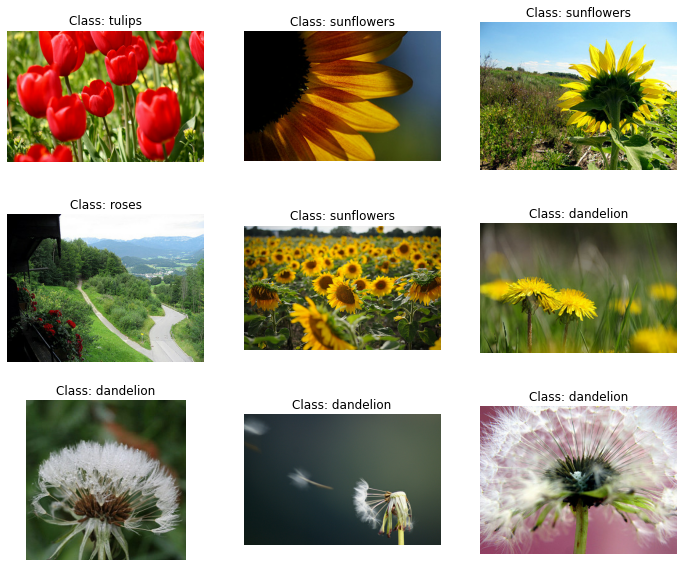

In [0]:
helpers.plot_images(train_data.take(9), class_names)

## Model Definition

In [0]:
# returns a standard CNN with provided or default parameters
def make_model(
  learning_rate=0.001,
  momentum=0.9,
  decay=0.002,
  dense_neurons=1000,
  n_filters=32,
  first_kernel_size=(7,7),
  activation='elu',
  noise=False
):
  input_layer = Input(shape=(224, 224, 3))
  input = BatchNormalization(axis=[1,2])(input_layer)

  if noise:
    input = GaussianNoise(0.1)(input_layer)

  model = Conv2D(
      filters=n_filters, 
      kernel_size=(7,7), 
      activation=activation
      )(input)
  model = BatchNormalization(axis=[1,2])(model)
  model = MaxPooling2D((2,2))(model)

  for i in range(2, 5):
    model = Conv2D(
        filters = i * n_filters, 
        kernel_size=(3,3), 
        activation=activation
      )(model)
    model = Conv2D(
      filters = i * n_filters, 
      kernel_size=(3,3), 
      activation=activation,
      padding='same'
    )(model)
    model = BatchNormalization(axis=[1,2])(model)
    model = MaxPooling2D((2,2))(model)

  model = Conv2D(filters = 5 * n_filters, 
    kernel_size=(3,3), 
    activation=activation, 
    padding='same'
  )(model)
  model = Conv2D(filters = 5 * n_filters, 
    kernel_size=(3,3), 
    activation=activation, 
    padding='same'
  )(model)
  model = BatchNormalization(axis=[1,2])(model)
  model = MaxPooling2D((2,2))(model)

  model = Flatten()(model)
  model = Dense(dense_neurons, activation=activation)(model)
  model = BatchNormalization()(model)
  model = Dropout(0.5)(model)

  model = Dense(dense_neurons / 2, activation=activation)(model)
  model = BatchNormalization()(model)
  model = Dropout(0.5)(model)

  output = Dense(n_classes, activation="softmax")(model)

  CNN_model = Model(input_layer, output)

  optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum) #, decay=decay)
  CNN_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
  
  return CNN_model


In [0]:
make_model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 3)       200704    
_________________________________________________________________
conv2d (Conv2D)              (None, 218, 218, 32)      4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 218, 218, 32)      190096    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 107, 64)      36928 

In [0]:
generator = tf.keras.preprocessing.image.ImageDataGenerator()
train_generator_empty = generator.flow(X, y)
test_generator = generator.flow(X_test, y_test)

In [0]:
# train the model without data augmentation
CNN_model=make_model()
history = CNN_model.fit(
    train_generator_empty,
    steps_per_epoch=92,
    epochs=40,
    validation_data=test_generator,
    validation_steps=23
)

Epoch 1/40
92/92 [==============================] - 11s 116ms/step - loss: 1.9810 - accuracy: 0.3818 - val_loss: 3.9195 - val_accuracy: 0.2166
Epoch 2/40
92/92 [==============================] - 10s 106ms/step - loss: 1.5421 - accuracy: 0.4768 - val_loss: 5.7420 - val_accuracy: 0.2207
Epoch 3/40
92/92 [==============================] - 10s 106ms/step - loss: 1.3680 - accuracy: 0.5089 - val_loss: 7.4919 - val_accuracy: 0.2207
Epoch 4/40
92/92 [==============================] - 10s 106ms/step - loss: 1.2272 - accuracy: 0.5412 - val_loss: 4.5611 - val_accuracy: 0.2153
Epoch 5/40
92/92 [==============================] - 10s 105ms/step - loss: 1.1585 - accuracy: 0.5783 - val_loss: 6.1456 - val_accuracy: 0.2221
Epoch 6/40
92/92 [==============================] - 10s 105ms/step - loss: 1.0950 - accuracy: 0.5937 - val_loss: 4.4782 - val_accuracy: 0.2371
Epoch 7/40
92/92 [==============================] - 10s 106ms/step - loss: 1.0415 - accuracy: 0.6046 - val_loss: 3.9009 - val_accuracy: 0.2643

## Training with Data Augmentation

In [0]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    # vertical_flip=True
)
train_generator = generator.flow(X, y)

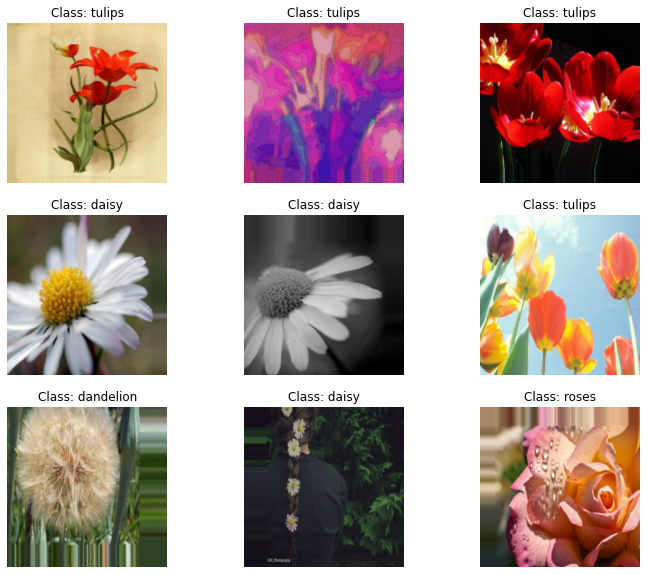

In [0]:
X_augmented, y_augmented = next(train_generator)
helpers.plot_images_with_labels((X_augmented[:9]+1)/2, y_augmented[:9].astype('int'), class_names)

In [0]:
data_augmentation_model = make_model(learning_rate=0.001, noise=True, n_filters=64)
# train a model with data augmentation and noise
history_data_augmentation = data_augmentation_model.fit(
    train_generator,
    steps_per_epoch=92,
    epochs=40,
    validation_data=test_generator,
    validation_steps=23
)

Epoch 1/40
92/92 [==============================] - 34s 364ms/step - loss: 2.0040 - accuracy: 0.3764 - val_loss: 2.0708 - val_accuracy: 0.2970
Epoch 2/40
92/92 [==============================] - 33s 362ms/step - loss: 1.6107 - accuracy: 0.4584 - val_loss: 1.3496 - val_accuracy: 0.4823
Epoch 3/40
92/92 [==============================] - 33s 362ms/step - loss: 1.4506 - accuracy: 0.4939 - val_loss: 1.1136 - val_accuracy: 0.5640
Epoch 4/40
92/92 [==============================] - 33s 359ms/step - loss: 1.3071 - accuracy: 0.5283 - val_loss: 1.1469 - val_accuracy: 0.5681
Epoch 5/40
92/92 [==============================] - 33s 360ms/step - loss: 1.2491 - accuracy: 0.5497 - val_loss: 1.1418 - val_accuracy: 0.5436
Epoch 6/40
92/92 [==============================] - 33s 357ms/step - loss: 1.1396 - accuracy: 0.5743 - val_loss: 1.0997 - val_accuracy: 0.5599
Epoch 7/40
92/92 [==============================] - 33s 357ms/step - loss: 1.1104 - accuracy: 0.5763 - val_loss: 0.9271 - val_accuracy: 0.6512

## Visualization

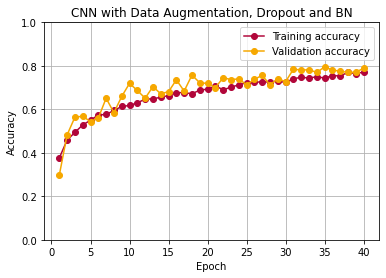

In [0]:
# plot_history('CNN without Data Augmentation', history, 0)
helpers.plot_history('CNN with Data Augmentation, Dropout and BN', history_data_augmentation, 0)
# validation accuracy might be sometimes higher than training accuracy due to 2 reasons:
#     - train acc is calculated as the mean of the whole epoch, test acc is calculated after each epoch
#       (where the model is better than in the mid of the epoch)
#     - when you use e.g. Dropout or aggressive data augmentation, the behavior at training time is different 